# BO insights

This notebook takes a look at the projected space of reaction and points being explored by the [default BO optimizer](./bo_initialization.ipynb), using the Morgan fingerprint (radius = 2, bit length = 1024).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import getMolFromSmile, SmilesToDescriptors
from rdkit.Chem.AllChem import GetMorganGenerator
import seaborn as sns
from baybe.utils.random import set_random_seed

set_random_seed(11)

c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#load the dataset, if not available run process_database.py first

df = pd.read_csv('dataset.csv')
df.head(2)

,reactant_1,reactant_2,reactant_3,product_R,product_S,solvent,catalyst_1,catalyst_2,product_undesired_R,product_undesired_S,ee_R,ee_S,ee_undesired_R,ee_undesired_S,yield_undesired_R,yield_undesired_S,reaction,curated_catalyst_2
0,c1ccc(C(=O)CBr)cc1,Cc1cccc(C)n1,C#CCCCCC=O,C#CCCC[C@H](C=O)CC(=O)c1ccccc1,C#CCCC[C@@H](C=O)CC(=O)c1ccccc1,CN(C)C=O,C1COCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,O=C[C@@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc...,O=C[C@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc3...,0.63,-0.63,0.0,0.0,0.095598,0.094402,C#CCCCCC=O.c1ccc(C(=O)CBr)cc1>C1COCCN1.F[P](F)...,F[P-](F)(F)(F)(F)F.CC(C)(C)C1=CC[N@H+]2C(=C1)C...
1,c1ccc(C(=O)CBr)cc1,Cc1cccc(C)n1,C#CCCCCC=O,C#CCCC[C@H](C=O)CC(=O)c1ccccc1,C#CCCC[C@@H](C=O)CC(=O)c1ccccc1,CN(C)C=O,C[Si](C)(C)OC(c1ccccc1)(c1ccccc1)[C@@H]1CCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,O=C[C@@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc...,O=C[C@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc3...,44.66,-44.66,0.0,0.0,0.412281,0.157719,C#CCCCCC=O.c1ccc(C(=O)CBr)cc1>C[Si](C)(C)OC(c1...,F[P-](F)(F)(F)(F)F.CC(C)(C)C1=CC[N@H+]2C(=C1)C...


In [3]:
reactant_1_pool = df['reactant_1'].unique()
catalyst_1_pool = df['catalyst_1'].unique()
catalyst_2_pool = df['catalyst_2'].unique()

In [4]:
#Computing the Morgan descriptors for the reactants and catalysts, Morgan radius = 2, bit vector length = 1024

reactant_1_descriptors = SmilesToDescriptors(reactant_1_pool, method='Morgan')
catalyst_1_descriptors = SmilesToDescriptors(catalyst_1_pool, method='Morgan')
catalyst_2_descriptors = SmilesToDescriptors(catalyst_2_pool, method='Morgan', sanitize=False)

reactant_1_descriptors.head(3)

,33,46,64,90,114,125,133,136,145,175,...,799,809,816,831,841,896,904,909,940,961
c1ccc(C(=O)CBr)cc1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
Cc1ccc(C(=O)CBr)cc1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
Oc1ccc(C(=O)CBr)cc1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
from baybe.targets import NumericalTarget
from baybe.objectives import SingleTargetObjective
from baybe.parameters import CustomDiscreteParameter, SubstanceParameter
from baybe.searchspace import SearchSpace

reactant_1_param = CustomDiscreteParameter(
    name='reactant_1',
    data=reactant_1_descriptors,
    decorrelate=0.7,
)

catalyst_1_param = CustomDiscreteParameter(
    name='catalyst_1',
    data=catalyst_1_descriptors,
    decorrelate=0.7,
)

catalyst_2_param = CustomDiscreteParameter(
    name='catalyst_2',
    data=catalyst_2_descriptors,
    decorrelate=0.7,
)

parameters = [
    reactant_1_param,
    catalyst_1_param,
    catalyst_2_param,
]

searchspace = SearchSpace.from_product(parameters)

target = NumericalTarget(
    name="ee_R",
    mode="MAX",
)

objective = SingleTargetObjective(target=target)

lookup = df[['reactant_1', 'catalyst_1', 'catalyst_2', 'ee_R']]
lookup.head(3)

,reactant_1,catalyst_1,catalyst_2,ee_R
0,c1ccc(C(=O)CBr)cc1,C1COCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,0.630000
1,c1ccc(C(=O)CBr)cc1,C[Si](C)(C)OC(c1ccccc1)(c1ccccc1)[C@@H]1CCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,44.660000
2,c1ccc(C(=O)CBr)cc1,C[C@@H]1[NH2+][C@@H](C(C)(C)C)N(C)C1=O.[O-]S(=...,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,79.949997


In [6]:
from baybe import Campaign
from baybe.simulation import simulate_scenarios
from baybe.recommenders import (
    BotorchRecommender,
    FPSRecommender,
    TwoPhaseMetaRecommender,
    RandomRecommender,
    )

BATCH_SIZE = 1
N_DOE_ITERATIONS = 50
N_MC_ITERATIONS = 5

botorch_fps_recommender = TwoPhaseMetaRecommender(
    initial_recommender=FPSRecommender(),   # farthest point sampling
    recommender=BotorchRecommender(),       # Bayesian optimization
    switch_after=10,                        # switch to Botorch after 10 iterations
    )

campaign = Campaign(searchspace=searchspace, objective=objective, recommender=botorch_fps_recommender)

In [7]:
print(f'Dimension of the reaction space: {campaign.searchspace.discrete.comp_rep.shape}')

Dimension of the reaction space: (1430, 86)


In [8]:
from baybe.simulation.lookup import look_up_targets

exp_indices =[]

#manual simulation loop to recover experiment indices
for i in range(N_DOE_ITERATIONS):
  measured = campaign.recommend(BATCH_SIZE)
  look_up_targets(measured, campaign.targets, lookup, "error")
  campaign.add_measurements(measured)
  exp_indices.append(measured.index[0])

In [9]:
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#load different projection methods
umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=25)
pca = PCA(n_components=2, random_state=42)
tsne = TSNE(n_components=2, random_state=42, perplexity=7)

#recover the experimental representation of the search space (here contains SMILES), add the ee_R to the representation
exrep = searchspace.discrete.exp_rep.copy()
look_up_targets(exrep, campaign.targets, lookup, "error")     #modify exrep inplace to include the target values (ee_R)

sp = campaign.searchspace.discrete.comp_rep   #recover the computed representation of the reaction space
sp_umap = umap_model.fit_transform(sp)        #fit transform the space
sp_pca = pca.fit_transform(sp)
sp_tsne = tsne.fit_transform(sp)

umap_path = sp_umap[exp_indices]    #recover the path from explored indices, note that the experimental and computed representations are identically indexed
pca_path = sp_pca[exp_indices]
tsne_path = sp_tsne[exp_indices]

exrep['umap_x'] = sp_umap[:, 0]   #add the coordinates to the df for plotting
exrep['umap_y'] = sp_umap[:, 1]
exrep['pca_x'] = sp_pca[:, 0]
exrep['pca_y'] = sp_pca[:, 1]
exrep['tsne_x'] = sp_tsne[:, 0]
exrep['tsne_y'] = sp_tsne[:, 1]


c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\gagne\miniconda3\envs\ai4chem\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
   

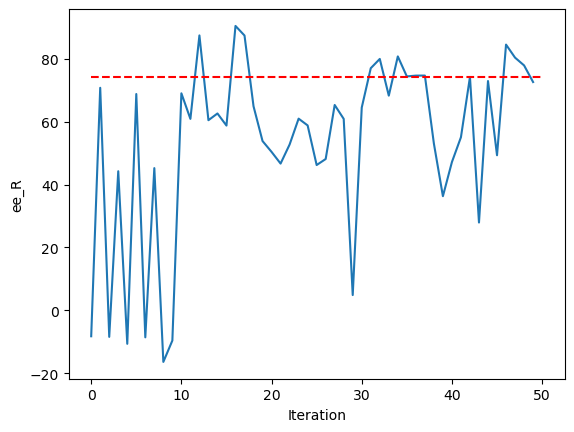

In [10]:
#plot the ee_R at every iterations, q99 plotted as red line
path = exrep.iloc[exp_indices]
plt.plot(path['ee_R'].values)
q = np.quantile(exrep['ee_R'], 0.99)
plt.hlines(q, 0, len(path), colors='r', linestyles='dashed')
plt.xlabel('Iteration')
plt.ylabel('ee_R')
plt.show()

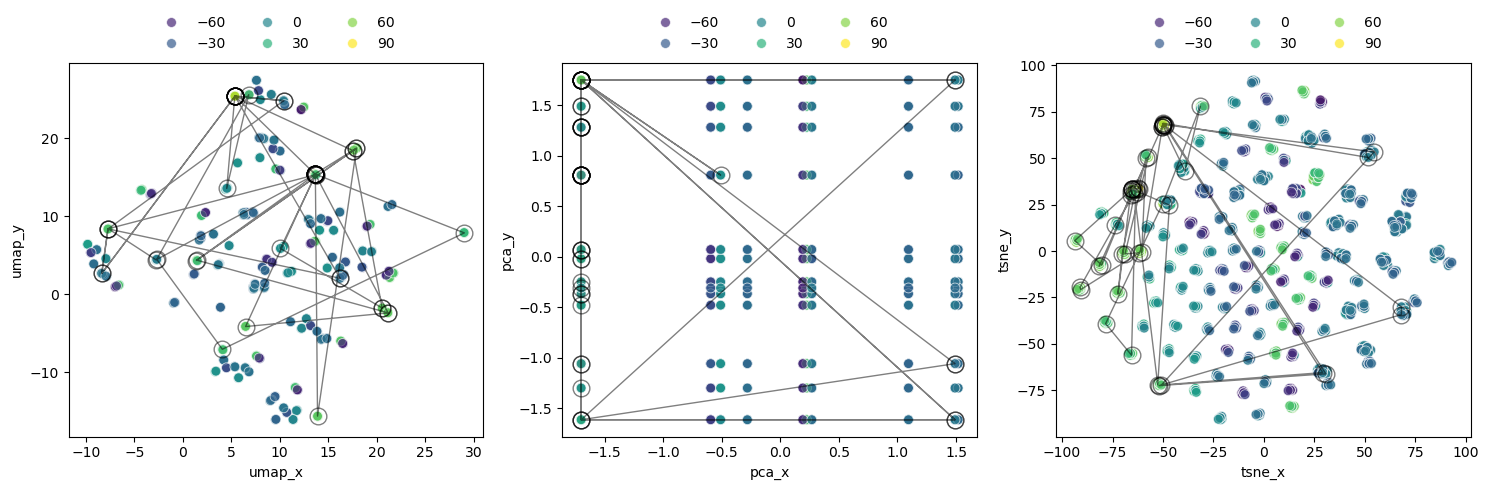

In [11]:
#plot the projected space superimposed with the explored points.

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(
    data=exrep,
    x='umap_x',
    y='umap_y',
    hue='ee_R',
    palette='viridis',
    alpha=0.7,
    s=50,
    ax=ax[0]
)

sns.scatterplot(
    data=exrep,
    x='pca_x',
    y='pca_y',
    hue='ee_R',
    palette='viridis',
    alpha=0.7,
    s=50,
    ax=ax[1]
)

sns.scatterplot(
    data=exrep,
    x='tsne_x',
    y='tsne_y',
    hue='ee_R',
    palette='viridis',
    alpha=0.7,
    s=50,
    ax=ax[2]
)

sns.move_legend(
    ax[0], "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)

sns.move_legend(
    ax[1], "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)

sns.move_legend(
    ax[2], "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)

ax[0].plot(umap_path[:, 0], umap_path[:, 1], markerfacecolor='none', markersize=12, marker='o', linewidth=1, alpha=0.5, color='black')
ax[1].plot(pca_path[:, 0], pca_path[:, 1], markerfacecolor='none', markersize=12, marker='o', linewidth=1, color='black', alpha=0.5)
ax[2].plot(tsne_path[:, 0], tsne_path[:, 1], markerfacecolor='none', markersize=12, marker='o', linewidth=1, alpha=0.5, color='black')
plt.tight_layout()

plt.savefig('./figures/projections_path.png', dpi=600, bbox_inches='tight')